In [103]:
import numpy as np
import qutip as qt
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
import os.path
import random
from cmt import *
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern'], 'size':25})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

/tmp/ipykernel_4971/2657460952.py:13: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


In [104]:
rank = 2 # rank of hamiltonian
kets = [qt.basis(2,i) for i in range(rank)]
projs = [qt.ket2dm(ket) for ket in kets]
c_ops =[]
psi0 = qt.fock(2,0)

e = 1.6e-19 #coulomb
h = 6.63e-34 *1e12/ e #eV ps
hbar = 1
hbar_eV = 6.582e-16 * 1e12 #eV ps
c = 3e8 * 1e-10 # cm/ps

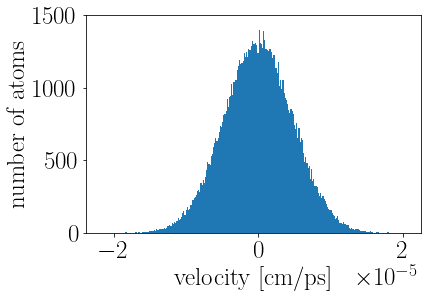

In [105]:
random.seed(0)
N_atoms = int(1e5)

T = 300 #K temperature of cloud
m = 2*9.1e-31 #kg
k = 1.38e-23 # [J K^-1]
std_deviation = np.sqrt(k*T/m) #standard deviation of gaussian
amplitude = np.sqrt(m/(2*np.pi*k*T))

velocities = np.random.normal(loc=0,scale=std_deviation,size=N_atoms) *1e-10#cm/ps

N_bins = 267 #calculated such that 1 bin is the equivalent of 1 unit of photon momentum for Ps
hist = plt.hist(velocities,bins=N_bins)

plt.ylim(0,1500)
plt.xlabel("velocity [cm/ps]")
plt.ylabel("number of atoms")
plt.show()

In [148]:
populations = hist[0]
velocity_bins = np.asarray([ hist[1][i] for i in range(N_bins)] )
# create new vector to track population: (velocity , population,) for cooling
states = np.asarray([velocity_bins,populations])

In [107]:
endTime =  20 #ps 
mass_ps = 1.022e6 # eV/ c^2 
wavelength = 243e-7 #cm
wavenumber = 2*np.pi/wavelength
momentum_per_photon = hbar_eV*wavenumber #eV ps cm^-1
velocity_change_per_photon = momentum_per_photon / mass_ps *c**2 #  cm/ps
print(velocity_change_per_photon, "cm/ps")
energy_splitting =  h*c/wavelength
omega0 = energy_splitting / hbar / hbar_eV# radians ps^-1
period = wavelength/c

binwidth = 2*np.pi/omega0*100
N_time = int(endTime/binwidth)
tlist = np.linspace(0,endTime,N_time)


pulse_duration = 10 #ps
tcentre = 10 #ps
tlist_centre = np.full(N_time,tcentre)

1.498728915411178e-07 cm/ps


In [140]:
rabi0 = 2*np.pi*(200e-3) #THz
detuning = 0#2*np.pi*(-152e-3) #THz
chirp = 2*np.pi*(70e-3) #THz

In [141]:
final_states = evolve(omega0,detuning,chirp,rabi0,pulse_duration) 

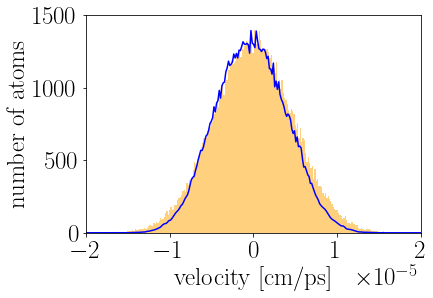

In [142]:
final_pops = np.asarray([np.abs(final_states[i][1][0][0]) for i in range(len(final_states))])
hist = plt.hist(velocities,bins=N_bins,alpha=0.5,color="orange")
plt.xlabel("velocity [cm/ps]")
plt.ylabel("number of atoms")
plt.ylim(0,1500)
plt.xlim(-2e-5,2e-5)
plt.plot(velocity_bins,final_pops*populations,color="blue")
plt.show()

In [164]:
detunings =  2*np.pi*np.asarray([-0.2,0,0.152,0.25])
final_pops = np.zeros((5,N_bins))
evolved_states = []
for i in range(detunings.size):
    evolved_states.append(evolve(omega0,detunings[i],chirp=0,rabi0=2*np.pi*(240e-3),pulse_duration=10))
    final_pops[i] = np.asarray([np.abs(evolved_states[i][j][1][0][0]) for j in range(N_bins)])

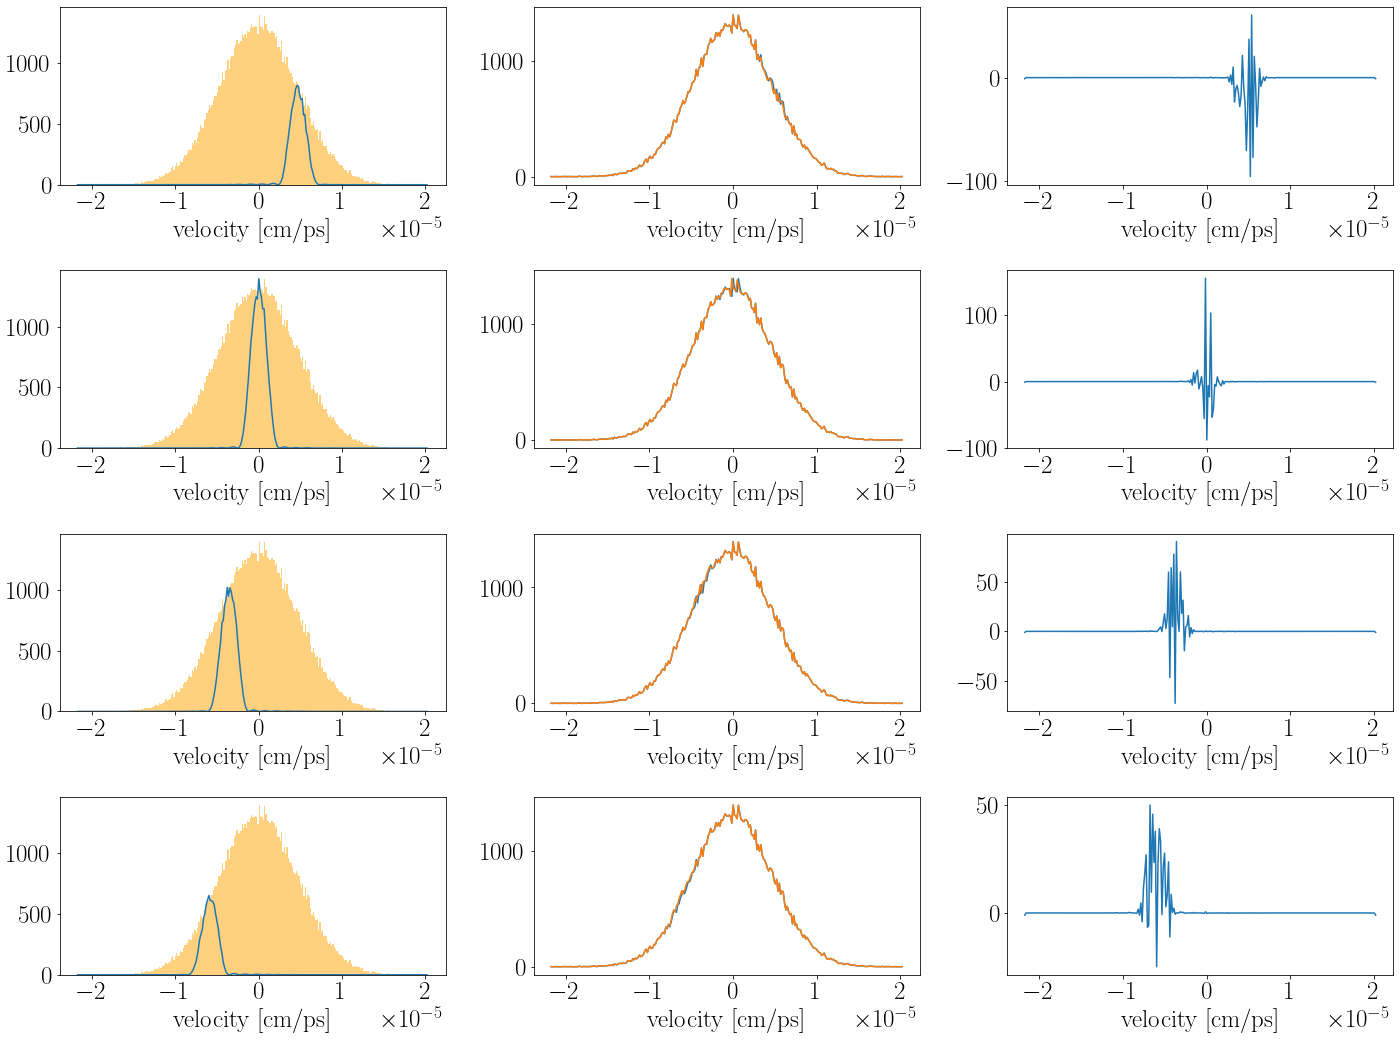

In [180]:
fig,axs = plt.subplots(detunings.size,3,figsize=(20,15))

for i in range(detunings.size):
    axs[i][0].hist(velocities,bins=N_bins,alpha=0.5,color="orange")
    axs[i][0].plot(velocity_bins,final_pops[i]*populations)
    axs[i][0].set_xlabel("velocity [cm/ps]")

    shifted_states = update_states(populations,evolved_states[i])
    axs[i][1].plot(velocity_bins, states[1],label="initial")
    axs[i][1].plot(velocity_bins,shifted_states,label="shifted")
    axs[i][1].set_xlabel("velocity [cm/ps]")
    #plt.legend()

    diffs = shifted_states - states[1]
    axs[i][2].plot(velocity_bins,diffs)
    axs[i][2].set_xlabel("velocity [cm/ps]")

    
    
fig.tight_layout()
plt.savefig("./figures/cmt/shifts.jpg")
plt.show()

Text(0.5, 0, 'velocity [cm/ps]')

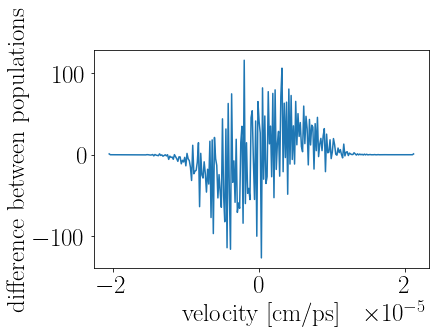

In [57]:
diff = np.asarray(states[1]-states_after_one_pulse[1])
plt.plot(velocity_bins, diff)
plt.ylabel("difference between populations")
plt.xlabel("velocity [cm/ps]")


In [138]:
test_detuning = 2*np.pi*(-152e-3) #THz
test_chirp = 0 #THz
test_rabi0 = 2*np.pi*(240e-3) #THz 
test_states = evolve(omega0,test_detuning,test_chirp,test_rabi0,pulse_duration)
test_final_pops = np.asarray([np.abs(final_states[i][1][0][0]) for i in range(len(final_states))])
test_states_after_one_pulse = update_states(states[1],test_final_pops)
test_diff = np.asarray(states[1]-test_states_after_one_pulse[1])

IndexError: invalid index to scalar variable.

In [ ]:
plt.plot(velocity_bins,states[1],color="orange",alpha=0.50)
plt.plot(velocity_bins,test_states_after_one_pulse[1])
plt.show()

In [ ]:
plt.plot(velocity_bins, test_diff)
plt.ylabel("difference between populations")
plt.xlabel("velocity [cm/ps]") 

In [127]:
interactions = final_states#evolve(omega0,detuning,chirp,rabi0,pulse_duration) 
list_of_populations = []
list_of_interactions = []
for i in range(10):
    interactions_arr = np.asarray([np.abs(interactions[i][1][0][0]) for i in range(N_bins)])
    list_of_interactions.append(interactions_arr)
    list_of_populations.append(interactions_arr*populations)
    # commented out since we're not updating velocities yet
    #populations = update_states(populations,interactions)
    interactions = evolve_train(omega0,detuning,chirp,rabi0,pulse_duration,interactions)



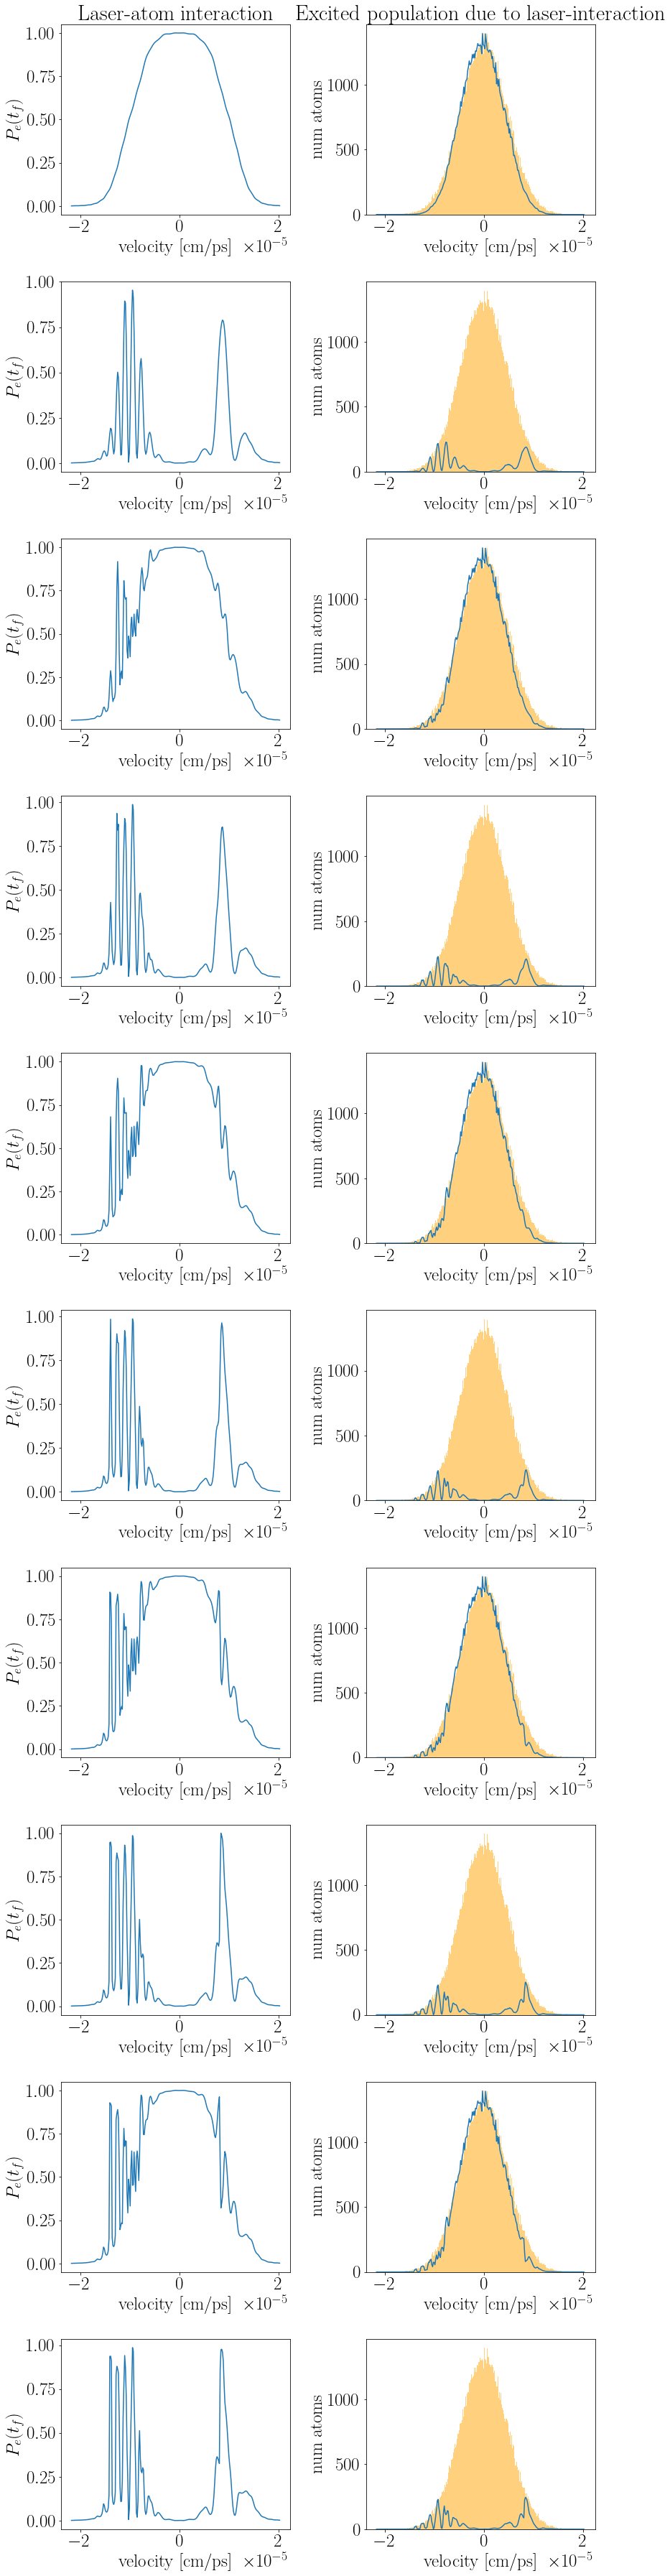

In [135]:
fig,axs = plt.subplots(10,2,figsize=(12,50))
for i in range(10):
    axs[i][0].plot(velocity_bins,list_of_interactions[i])
    axs[i][0].set_xlabel("velocity [cm/ps]")
    axs[i][0].set_ylabel(r"$P_e(t_f)$")
    
    axs[i][1].hist(velocities,bins=N_bins,alpha=0.5,color="orange")
    axs[i][1].plot(velocity_bins,list_of_populations[i])
    axs[i][1].set_xlabel("velocity [cm/ps]")
    axs[i][1].set_ylabel("num atoms")
    
fig.tight_layout()
axs[0][0].set_title("Laser-atom interaction")
axs[0][1].set_title("Excited population due to laser-interaction")
plt.savefig("./figures/cmt/interaction_after_3_pulses.png")
plt.show()